In [39]:
import sys

assert sys.version_info >= (3, 7)

In [40]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [41]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [42]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "U-Net"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [43]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardwar "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Acclerator and select GPU.")

In [44]:
import numpy as np

mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [45]:
X_train.shape

(55000, 28, 28, 1)

_U-Net Architecture_

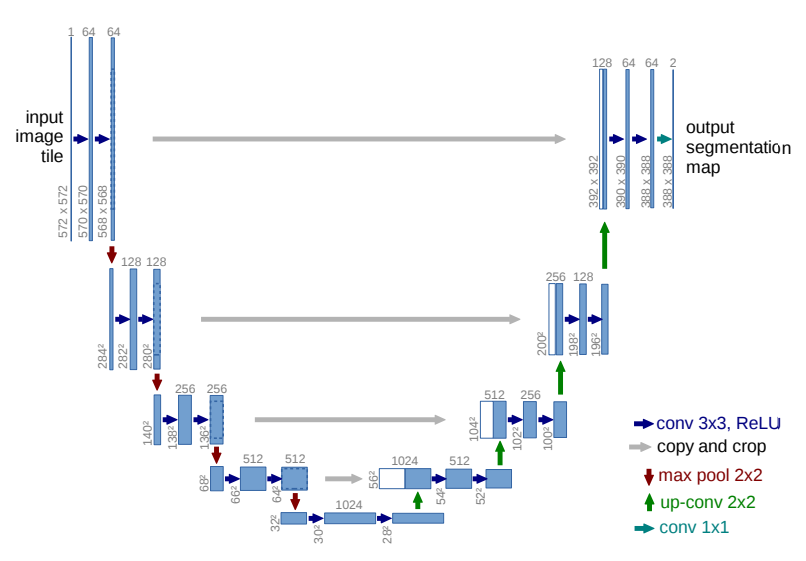

Network Architecture consists of a **contracting path** (left side) and an **expansive path** (right side). The contracting path follows the typical architecture of a convolutional network. It consists of the repeated application of two $3 \times 3$ convolutions (unpadded convolutions), each followed by a rectified linear unit (ReLU) and a $2 \times 2$ max pooling operation with stride 2 for downsampling. At each downsampling step we double the number of feature channels. Every step in the expansive path consists of an upsampling of the feature map followed by a $2 \times 2$ convolution ("up-convolution") that halves the number of feature channels, a concatenation with the correspondingly cropped feature map from the contracting path, and two $3 \times 3$ convolutions, each followed by a ReLU. The cropping is necessary due to the loss of border pixels in every convolution. At the final layer a $1 \times 1$ convolution is used to map each 64-component feature vector to the desired number of classes. In total the network has 23 convolutional layers.

In [46]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        activation="relu")
DefaultMaxPool2D = partial(tf.keras.layers.MaxPool2D, pool_size=2, strides=2)
DefaultConv2DTranspose = partial(tf.keras.layers.Conv2DTranspose, kernel_size=3, 
                                 strides=2, padding="same")

In [47]:
class MyConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, **kwargs):
        super().__init__(**kwargs)
        # self.conv_layer1 = DefaultConv2D(filters=filters)
        # self.conv_layer2 = DefaultConv2D(filters=filters)

        self.doubleConv = tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=filters, kernel_size=3, 
                                    strides=1, kernel_initializer="he_normal",
                                    padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(filters=filters, kernel_size=3,
                                    strides=1, kernel_initializer="he_normal",
                                    padding="same"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU()
        ])
    
    def call(self, X):
        return self.doubleConv(X)

In [52]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

resize_layer = tf.keras.layers.Resizing(height=128, width=128)

norm_layer = tf.keras.layers.Normalization()

# Contracting Path
conv_layer1 = MyConv2D(64)
pool_layer1 = DefaultMaxPool2D()

conv_layer2 = MyConv2D(128)
pool_layer2 = DefaultMaxPool2D()

conv_layer3 = MyConv2D(256)
pool_layer3 = DefaultMaxPool2D()

conv_layer4 = MyConv2D(512)
pool_layer4 = DefaultMaxPool2D()

# Bottleneck
conv_layer5 = MyConv2D(1024)

# Expansive Path
conv_T_layer1 = DefaultConv2DTranspose(filters=512)
concat_layer1 = tf.keras.layers.Concatenate()
conv_layer6 = MyConv2D(512)

conv_T_layer2 = DefaultConv2DTranspose(filters=256)
concat_layer2 = tf.keras.layers.Concatenate()
conv_layer7 = MyConv2D(256)

conv_T_layer3 = DefaultConv2DTranspose(filters=128)
concat_layer3 = tf.keras.layers.Concatenate()
conv_layer8 = MyConv2D(128)

conv_T_layer4 = DefaultConv2DTranspose(filters=64)
concat_layer4 = tf.keras.layers.Concatenate()
conv_layer9 = MyConv2D(64)

# final layer
output_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=1, activation="softmax")


input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
resized = resize_layer(input_)
normalized = norm_layer(resized)

conv1 = conv_layer1(normalized)
pool1 = pool_layer1(conv1)

conv2 = conv_layer2(pool1)
pool2 = pool_layer2(conv2)

conv3 = conv_layer3(pool2)
pool3 = pool_layer3(conv3)

conv4 = conv_layer4(pool3)
pool4 = pool_layer4(conv4)


conv5 = conv_layer5(pool4)


conv_T1 = conv_T_layer1(conv5)
concat1 = concat_layer1([conv4, conv_T1])
conv6 = conv_layer6(concat1)

conv_T2 = conv_T_layer2(conv6)
concat2 = concat_layer2([conv3, conv_T2])
conv7 = conv_layer7(concat2)

conv_T3 = conv_T_layer3(conv7)
concat3 = concat_layer3([conv2, conv_T3])
conv8 = conv_layer8(concat3)

conv_T4 = conv_T_layer4(conv8)
concat4 = concat_layer4([conv1, conv_T4])
conv9 = conv_layer9(concat4)

output = output_layer(conv9)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [53]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 resizing (Resizing)            (None, 128, 128, 1)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 1)  3           ['resizing[0][0]']               
                                                                                                  
 my_conv2d (MyConv2D)           (None, 128, 128, 64  38080       ['normalization[0][0]']          
                                )                                                             

In [54]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10,
                                                     restore_best_weights=True)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10


ValueError: in user code:

    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\losses.py", line 1990, in categorical_crossentropy
        return backend.categorical_crossentropy(
    File "c:\Users\HP\.conda\envs\tf\lib\site-packages\keras\backend.py", line 5529, in categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)

    ValueError: Shapes (None,) and (None, 128, 128, 1) are incompatible
